#### Install libraries on the host

In [1]:
# uncomment the magic command if you need to install libraries

#%pip install pandas seaborn xgboost scikit-learn holidays requests

#### import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import holidays
import requests as r
import io
import os
from pathlib import Path
import csv
import glob

In [3]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#### Download files to local if running or the first time

In [4]:
download_files = False

In [5]:
def download_weather_data(start_year=2016,
                         end_year=2024,
                         station_id=51459):
    
    local_path = f".{os.sep}data{os.sep}weather-data{os.sep}"
    print(f"Weather data will be saved in {local_path}")
    Path(local_path).mkdir(parents=True, exist_ok=True)
    
    for year in range(start_year, end_year+1):
        
        for month in range(12):
            url = f"https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=51459&Year={year}&Month={month+1}&Day=1&timeframe=1&submit= Download+Data"
            file = f"{local_path}{os.sep}{year}_{month+1}.csv"
            print(f"Downloading weather data for year: {year}, month: {month+1} into file: {file}")
            response = r.get(url)
            df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))
            df.to_csv(file, index=False, header=True, quoting=csv.QUOTE_ALL)

    print("== done ==")

In [6]:
def download_ferry_ticket_data():
    url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/toronto-island-ferry-ticket-counts/resource/c46719f5-8006-44e1-8b1e-5ad90bb9f6f4/download/Toronto%20Island%20Ferry%20Ticket%20Counts.csv"
    file = f".{os.sep}data{os.sep}toronto_island_ferry_ticket_counts.csv"
    print(f"Downloading Toronto ferry traffic data from Toronto Open Data portal into file: {file}")
    response = r.get(url)
    df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))
    df.to_csv(file, index=False, header=True, quoting=csv.QUOTE_ALL)
    print("== done ==")
    

In [7]:
if download_files:
    download_weather_data()
    download_ferry_ticket_data()

#### Load data and perform EDA

In [8]:
ca_holidays = holidays.country_holidays('CA')

def is_holiday(timestamp):    
    return timestamp in ca_holidays

In [9]:


def extract_datetime_features(df):
    """
        Extract year, month, day, day_of_month, day_of_week
                day_of_year, week_of_year, quarter,
                hour, minute
        from index that is in datetime format
    """
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week
    #df['quarter'] = df.index.quarter
    df['hour'] = df.index.hour
    df['minute'] = df.index.hour
    
    return df

In [10]:
def add_lags(df, target_column):
    target_map = df[target_column].to_dict()
    df['lag_1'] = (df.index - pd.Timedelta('15 minutes')).map(target_map)
    df['lag_2'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag_3'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    return df

In [11]:
# load ferry usage data

df = pd.read_csv("data/toronto_island_ferry_ticket_counts.csv")

In [12]:
# rename columns and drop extra columns

df = df.rename(columns={'Timestamp': 'timestamp', 'Redemption Count': 'redemption_count'})
df.drop(['_id','Sales Count'], axis=1, inplace=True)

In [13]:
df['is_holiday'] = df['timestamp'].apply(is_holiday)

In [14]:
# setting timestamp as index then converting index as timestamp

df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)

In [15]:
df.head()

,redemption_count,is_holiday
timestamp,,
2025-03-21 18:45:00,6,False
2025-03-21 18:30:00,66,False
2025-03-21 18:15:00,32,False
2025-03-21 18:00:00,33,False
2025-03-21 17:45:00,13,False


In [16]:
# we have observations for every 15 minutes

In [17]:
# let's check for nulls 

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240861 entries, 2025-03-21 18:45:00 to 2015-05-01 13:30:00
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   redemption_count  240861 non-null  int64
 1   is_holiday        240861 non-null  bool 
dtypes: bool(1), int64(1)
memory usage: 3.9 MB


In [18]:
# looks like we don't have any nulls
# let's start plotting the data and perform further analysis

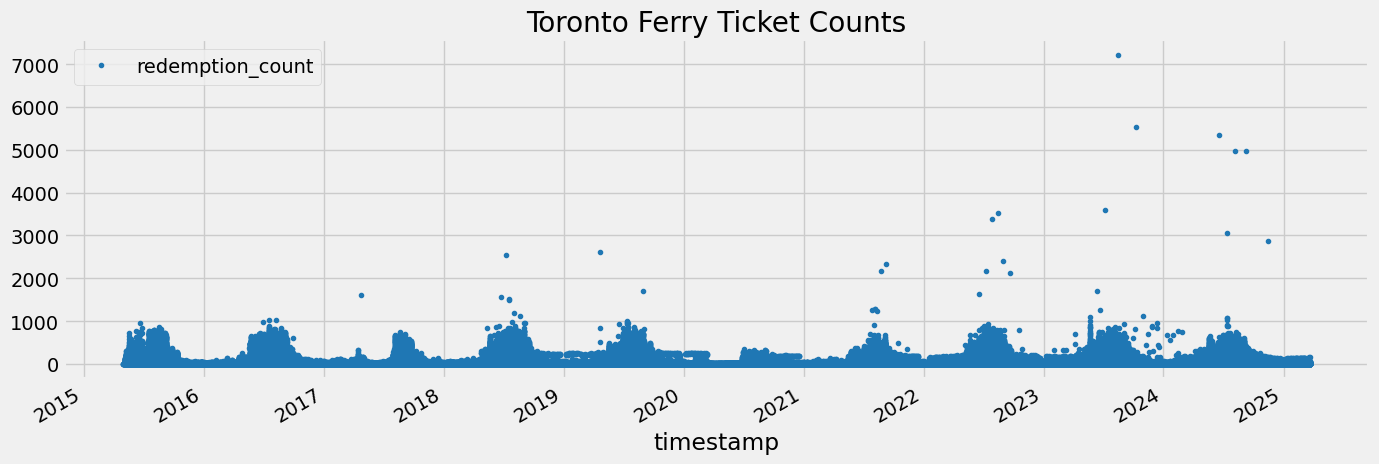

In [19]:
# plotting the initial distribution of our full dataset

df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Toronto Ferry Ticket Counts')
plt.show()

In [20]:
# removing partial years 2015 and 2025

df = df.loc[df.index.year < 2025]
df = df.loc[df.index.year > 2015]
df.groupby(df.index.year).count()

,redemption_count,is_holiday
timestamp,,
2016,23240,23240
2017,22101,22101
2018,24665,24665
2019,24670,24670
2020,22741,22741
2021,25231,25231
2022,25733,25733
2023,26295,26295
2024,26261,26261


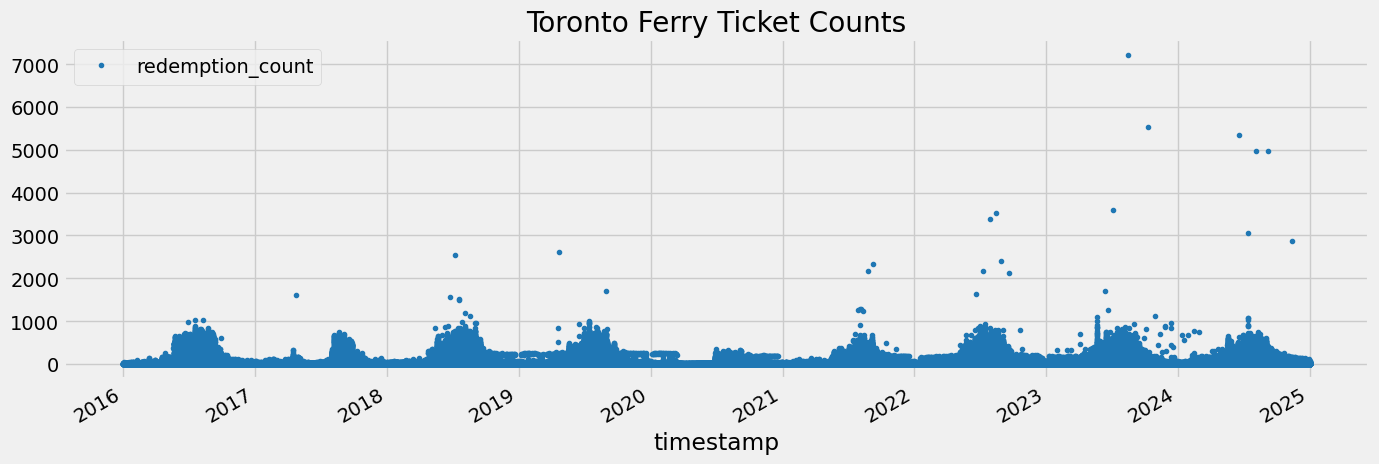

In [21]:
# plotting the initial distribution of our full dataset again

df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Toronto Ferry Ticket Counts')
plt.show()

In [22]:
# we see some possible outliers. we may need to deal with them soon

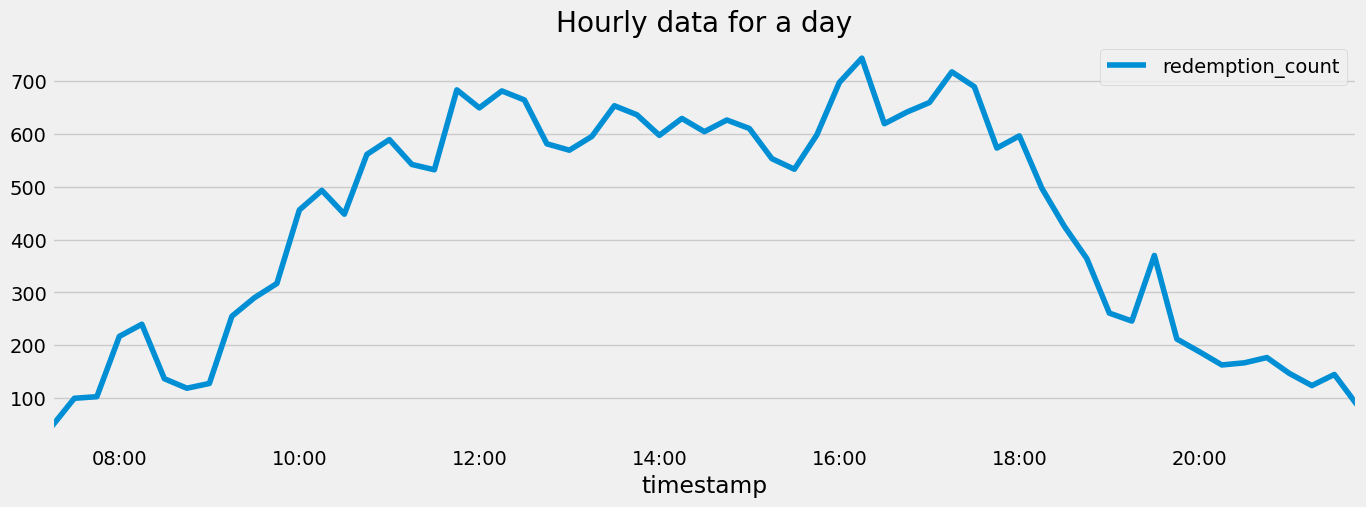

In [23]:
# let's have a look at an hourly slice for a day

df.loc[(df.index > '07-01-2018 07:00:00') & (df.index < '07-01-2018 22:00:00')] \
    .plot(figsize=(15, 5), title='Hourly data for a day')
plt.show()

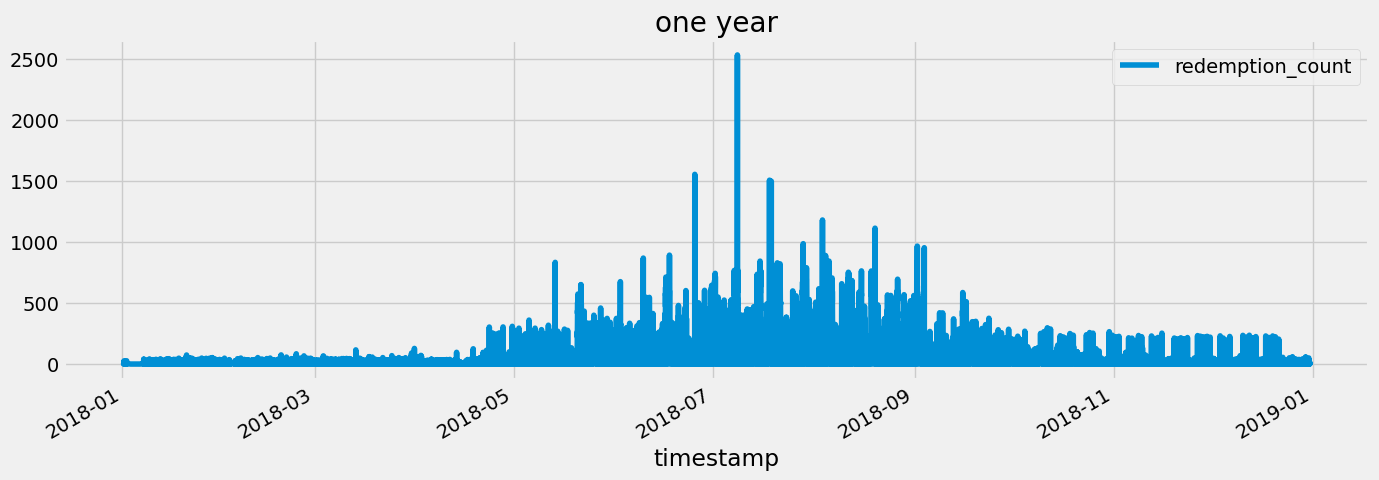

In [24]:
# and here is a plot of a year's data

df.loc[(df.index > '01-01-2018') & (df.index < '12-31-2018')] \
    .plot(figsize=(15, 5), title='one year')
plt.show()

In [25]:
# since we have hourly data, let's extract some datetime features
# this will help us further analyze the data

df = extract_datetime_features(df)
df

,redemption_count,is_holiday,year,month,day_of_month,day_of_week,day_of_year,week_of_year,hour,minute
timestamp,,,,,,,,,,
2024-12-31 23:30:00,6,False,2024,12,31,1,366,1,23,23
2024-12-31 23:15:00,0,False,2024,12,31,1,366,1,23,23
2024-12-31 23:00:00,6,False,2024,12,31,1,366,1,23,23
2024-12-31 22:45:00,0,False,2024,12,31,1,366,1,22,22
2024-12-31 22:30:00,1,False,2024,12,31,1,366,1,22,22
...,...,...,...,...,...,...,...,...,...,...
2016-01-01 09:30:00,0,True,2016,1,1,4,1,53,9,9
2016-01-01 09:00:00,2,True,2016,1,1,4,1,53,9,9
2016-01-01 08:15:00,1,True,2016,1,1,4,1,53,8,8


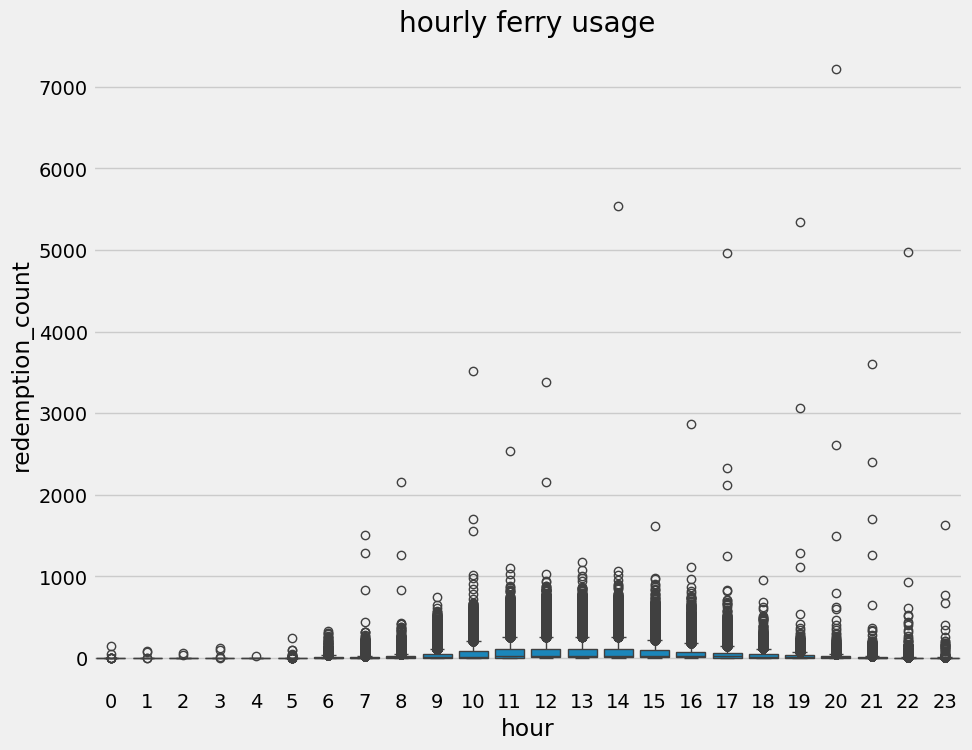

In [26]:
# let's plot hourly data

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='redemption_count')
ax.set_title('hourly ferry usage')
plt.show()

In [27]:
# clearly we have some outliers. 
# let's look at an anova table

df.describe()

,redemption_count,year,month,day_of_month,day_of_week,day_of_year,week_of_year,hour,minute
count,220937.000000,220937.000000,220937.000000,220937.000000,220937.000000,220937.000000,220937.0,220937.000000,220937.000000
mean,46.562187,2020.123850,6.683933,15.752821,3.008111,188.083191,27.231365,13.656205,13.656205
std,101.554887,2.584422,3.282680,8.815486,1.989569,100.307370,14.3231,5.659833,5.659833
min,0.000000,2016.000000,1.000000,1.000000,0.000000,1.000000,1.0,0.000000,0.000000
25%,3.000000,2018.000000,4.000000,8.000000,1.000000,106.000000,15.0,9.000000,9.000000
50%,10.000000,2020.000000,7.000000,16.000000,3.000000,193.000000,28.0,14.000000,14.000000
75%,37.000000,2022.000000,9.000000,23.000000,5.000000,270.000000,39.0,18.000000,18.000000
max,7216.000000,2024.000000,12.000000,31.000000,6.000000,366.000000,53.0,23.000000,23.000000


In [28]:
# As we can see from the redemption_count column, there are some extreme outliers. 
# Let's try to clean that up using IQR. 

Q1 = df['redemption_count'].quantile(0.25)
Q3 = df['redemption_count'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

In [29]:
print(f"lower: {lower}, upper: {upper}" )

lower: -48.0, upper: 88.0


In [30]:
# removing outlier values outside partial years 2015 and 2025

df = df.loc[df.redemption_count > lower]
df = df.loc[df.redemption_count < upper]

In [31]:
df.describe()

,redemption_count,year,month,day_of_month,day_of_week,day_of_year,week_of_year,hour,minute
count,189493.000000,189493.000000,189493.000000,189493.000000,189493.000000,189493.000000,189493.0,189493.000000,189493.000000
mean,15.157811,2020.104959,6.578612,15.732961,2.929306,184.890904,26.797987,13.697604,13.697604
std,18.998333,2.550867,3.480102,8.786896,1.966970,106.400802,15.196677,5.999604,5.999604
min,0.000000,2016.000000,1.000000,1.000000,0.000000,1.000000,1.0,0.000000,0.000000
25%,2.000000,2018.000000,4.000000,8.000000,1.000000,92.000000,14.0,9.000000,9.000000
50%,7.000000,2020.000000,7.000000,16.000000,3.000000,183.000000,27.0,14.000000,14.000000
75%,20.000000,2022.000000,10.000000,23.000000,5.000000,280.000000,40.0,19.000000,19.000000
max,87.000000,2024.000000,12.000000,31.000000,6.000000,366.000000,53.0,23.000000,23.000000


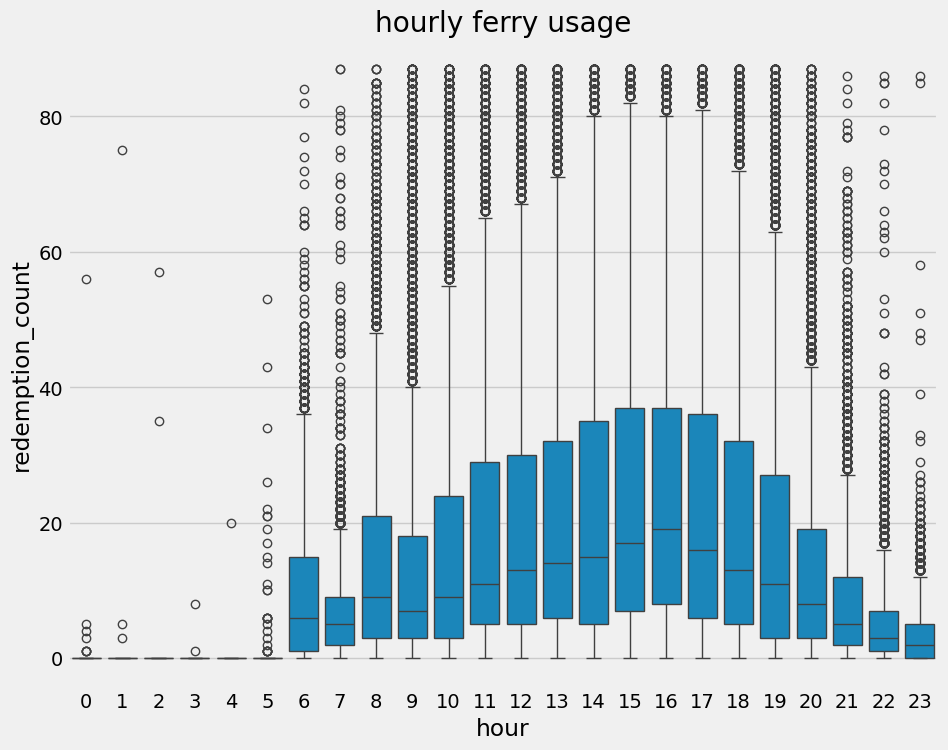

In [32]:
# with outliers removed, let's plot again

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='redemption_count')
ax.set_title('hourly ferry usage')
plt.show()

In [33]:
# we still have some outliers between midnight and 5am
# let's come back to that one

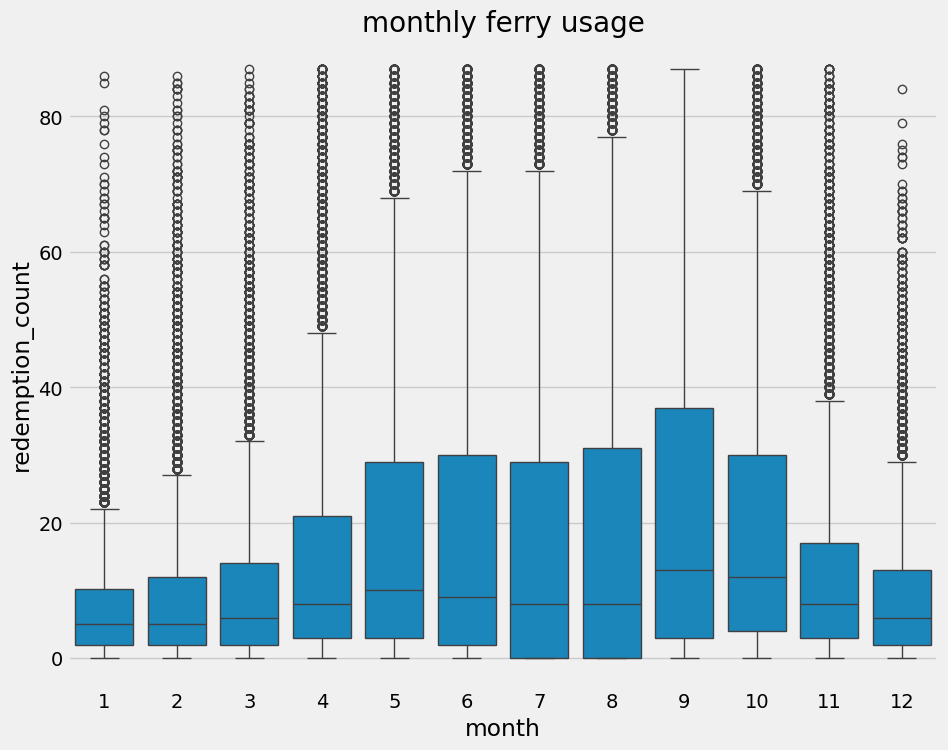

In [34]:
# plot monthly ferry usage

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='redemption_count')
ax.set_title('monthly ferry usage')
plt.show()

In [35]:
# this looks good, no major issues

In [36]:
# let's remove any records before 5am and replot

df = df.loc[df.hour > 5]


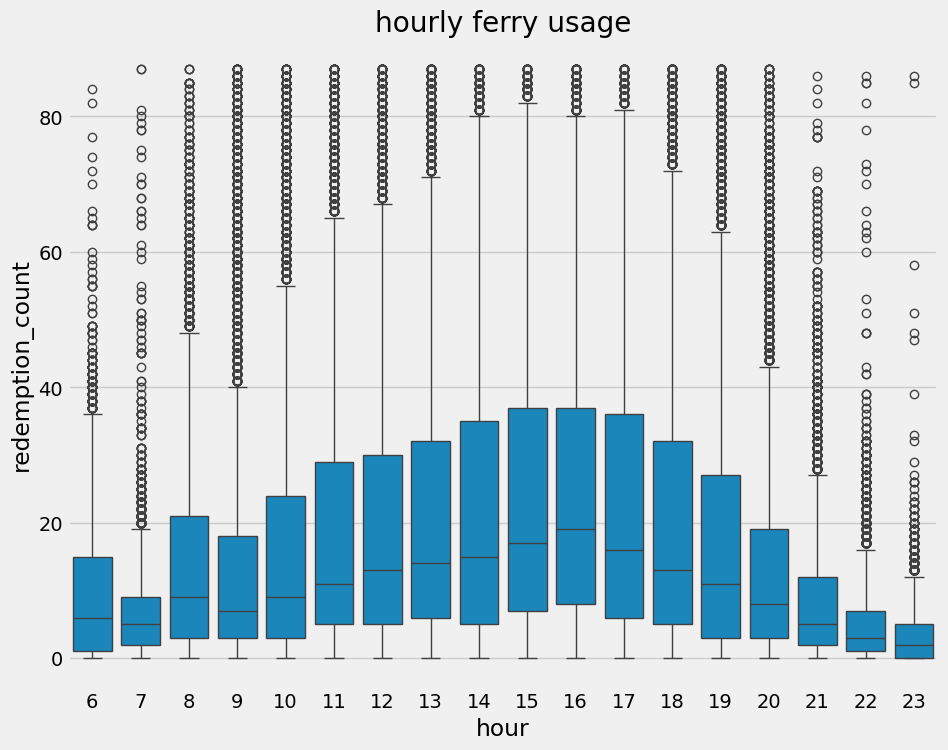

In [37]:
# replot after remove 0 - 5 hours

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='redemption_count')
ax.set_title('hourly ferry usage')
plt.show()

In [38]:
# okay, this is much cleaner, next we train model

In [39]:
# combine weather data
# read all weather data into one dataframe

In [40]:
weather_data_path = f".{os.sep}data{os.sep}weather-data{os.sep}*.csv"
all_weather_files = glob.glob(weather_data_path)
df_weather = pd.concat((pd.read_csv(f) for f in all_weather_files), ignore_index=True)

In [41]:
df_weather

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Flag,...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,-79.63,43.68,TORONTO INTL A,6158731,2023-06-01 00:00,2023,6,1,00:00,NaN,...,NaN,24.1,NaN,99.89,NaN,25.0,NaN,NaN,NaN,NaN
1,-79.63,43.68,TORONTO INTL A,6158731,2023-06-01 01:00,2023,6,1,01:00,NaN,...,NaN,24.1,NaN,99.88,NaN,NaN,NaN,NaN,NaN,Clear
2,-79.63,43.68,TORONTO INTL A,6158731,2023-06-01 02:00,2023,6,1,02:00,NaN,...,NaN,24.1,NaN,99.87,NaN,NaN,NaN,NaN,NaN,NaN
3,-79.63,43.68,TORONTO INTL A,6158731,2023-06-01 03:00,2023,6,1,03:00,NaN,...,NaN,24.1,NaN,99.88,NaN,NaN,NaN,NaN,NaN,NaN
4,-79.63,43.68,TORONTO INTL A,6158731,2023-06-01 04:00,2023,6,1,04:00,NaN,...,NaN,24.1,NaN,99.91,NaN,NaN,NaN,NaN,NaN,Mainly Clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78907,-79.63,43.68,TORONTO INTL A,6158731,2024-10-31 19:00,2024,10,31,19:00,NaN,...,NaN,24.1,NaN,98.74,NaN,26.0,NaN,NaN,NaN,Mostly Cloudy
78908,-79.63,43.68,TORONTO INTL A,6158731,2024-10-31 20:00,2024,10,31,20:00,NaN,...,NaN,24.1,NaN,98.70,NaN,NaN,NaN,NaN,NaN,Rain
78909,-79.63,43.68,TORONTO INTL A,6158731,2024-10-31 21:00,2024,10,31,21:00,NaN,...,NaN,19.3,NaN,98.70,NaN,NaN,NaN,NaN,NaN,Rain
78910,-79.63,43.68,TORONTO INTL A,6158731,2024-10-31 22:00,2024,10,31,22:00,NaN,...,NaN,19.3,NaN,98.69,NaN,NaN,NaN,NaN,NaN,Rain


In [42]:
df_weather.columns

Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'Date/Time (LST)', 'Year', 'Month', 'Day', 'Time (LST)', 'Flag',
       'Temp (°C)', 'Temp Flag', 'Dew Point Temp (°C)', 'Dew Point Temp Flag',
       'Rel Hum (%)', 'Rel Hum Flag', 'Precip. Amount (mm)',
       'Precip. Amount Flag', 'Wind Dir (10s deg)', 'Wind Dir Flag',
       'Wind Spd (km/h)', 'Wind Spd Flag', 'Visibility (km)',
       'Visibility Flag', 'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx',
       'Hmdx Flag', 'Wind Chill', 'Wind Chill Flag', 'Weather'],
      dtype='object')

In [43]:
df_weather = df_weather[['Year', 'Month', 'Day', 'Time (LST)', 'Temp (°C)']]

In [44]:
df_weather = df_weather.rename(columns={'Year': 'year', 
                                        'Month': 'month', 
                                        'Day': 'day_of_month', 
                                        'Time (LST)': 'hour_minute', 
                                        'Temp (°C)': 'temp_c'})

In [45]:
df_weather['hour'] = df_weather['hour_minute'].str.slice(0,2).astype('int')

In [46]:
df_weather.drop(['hour_minute'], axis=1, inplace=True)

In [47]:
df_weather

,year,month,day_of_month,temp_c,hour
0,2023,6,1,22.6,0
1,2023,6,1,21.1,1
2,2023,6,1,21.2,2
3,2023,6,1,19.3,3
4,2023,6,1,20.0,4
...,...,...,...,...,...
78907,2024,10,31,21.6,19
78908,2024,10,31,20.0,20
78909,2024,10,31,18.0,21
78910,2024,10,31,18.0,22


In [48]:
df

,redemption_count,is_holiday,year,month,day_of_month,day_of_week,day_of_year,week_of_year,hour,minute
timestamp,,,,,,,,,,
2024-12-31 23:30:00,6,False,2024,12,31,1,366,1,23,23
2024-12-31 23:15:00,0,False,2024,12,31,1,366,1,23,23
2024-12-31 23:00:00,6,False,2024,12,31,1,366,1,23,23
2024-12-31 22:45:00,0,False,2024,12,31,1,366,1,22,22
2024-12-31 22:30:00,1,False,2024,12,31,1,366,1,22,22
...,...,...,...,...,...,...,...,...,...,...
2016-01-01 09:30:00,0,True,2016,1,1,4,1,53,9,9
2016-01-01 09:00:00,2,True,2016,1,1,4,1,53,9,9
2016-01-01 08:15:00,1,True,2016,1,1,4,1,53,8,8


In [49]:
df = df.reset_index().merge(df_weather, 
                            left_on=['year','month', 'day_of_month', 'hour'], 
                            right_on = ['year','month', 'day_of_month', 'hour'], 
                            how='left').set_index('timestamp')

In [50]:
df

,redemption_count,is_holiday,year,month,day_of_month,day_of_week,day_of_year,week_of_year,hour,minute,temp_c
timestamp,,,,,,,,,,,
2024-12-31 23:30:00,6,False,2024,12,31,1,366,1,23,23,2.4
2024-12-31 23:15:00,0,False,2024,12,31,1,366,1,23,23,2.4
2024-12-31 23:00:00,6,False,2024,12,31,1,366,1,23,23,2.4
2024-12-31 22:45:00,0,False,2024,12,31,1,366,1,22,22,2.7
2024-12-31 22:30:00,1,False,2024,12,31,1,366,1,22,22,2.7
...,...,...,...,...,...,...,...,...,...,...,...
2016-01-01 09:30:00,0,True,2016,1,1,4,1,53,9,9,-2.6
2016-01-01 09:00:00,2,True,2016,1,1,4,1,53,9,9,-2.6
2016-01-01 08:15:00,1,True,2016,1,1,4,1,53,8,8,-1.3


#### Train and Test

In [51]:
# timeseries split

tss = TimeSeriesSplit(n_splits=5, test_size=24*1*365, gap=24)
df = df.sort_index()

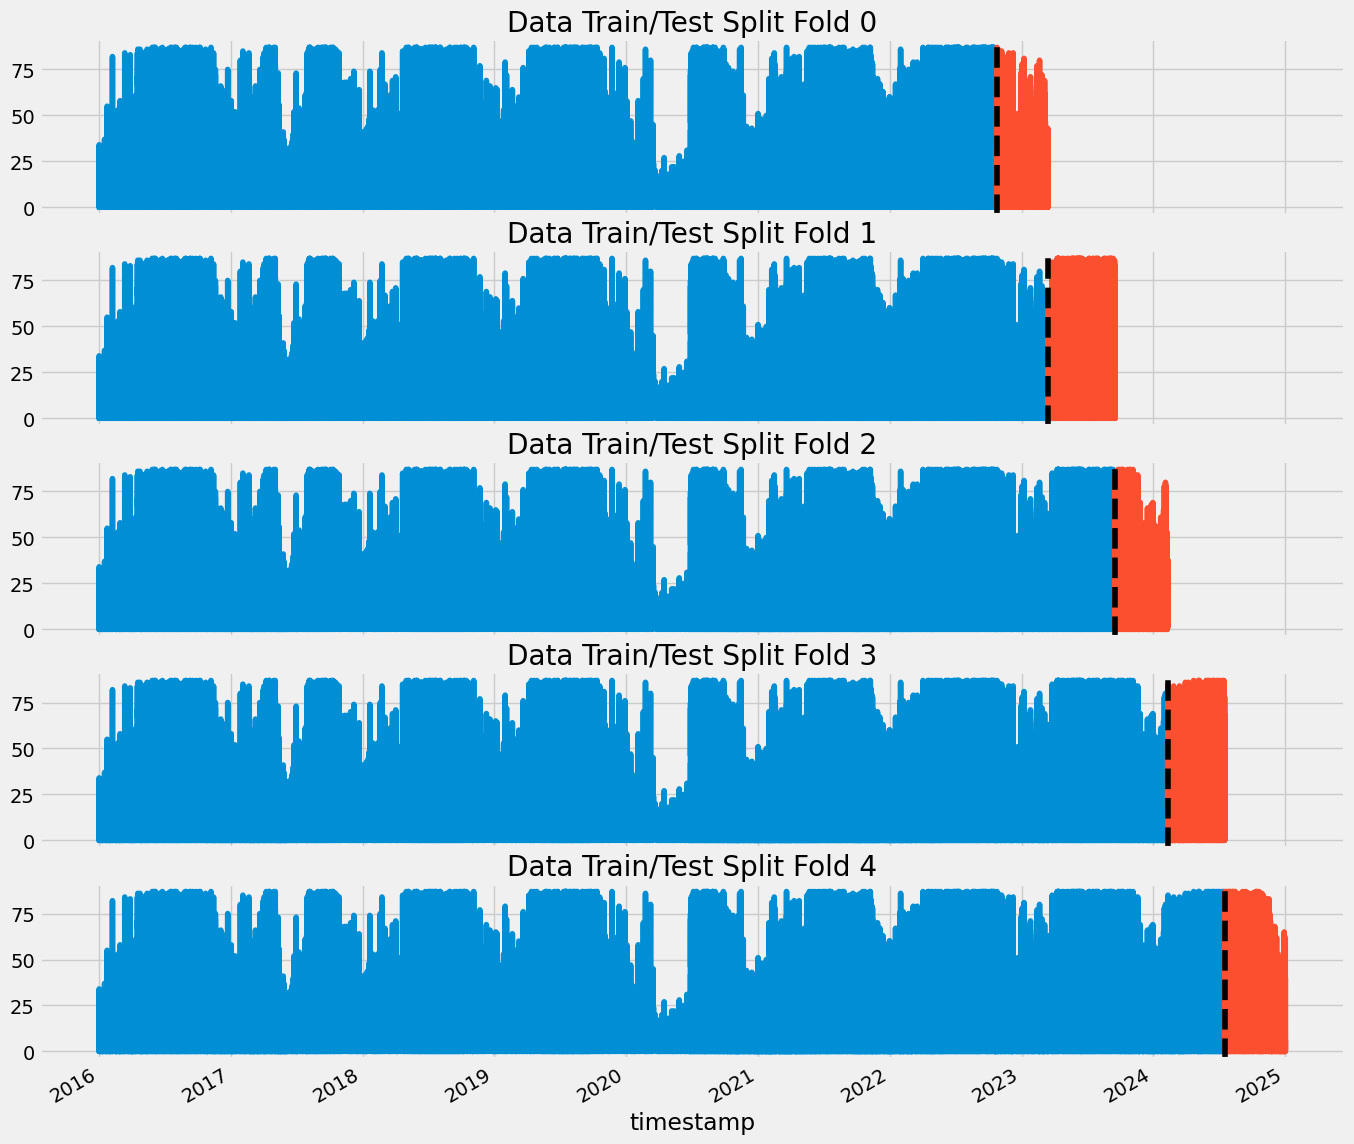

In [52]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['redemption_count'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['redemption_count'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [53]:
#### lag features

df = add_lags(df, target_column='redemption_count')


In [54]:
FEATURES = ['day_of_year', 'hour', 'day_of_week',
             'month', 'year', 'temp_c',
            'lag_1', 'lag_2', 'lag_3',
           'is_holiday']
TARGET = 'redemption_count'

In [55]:
# cross validation

df = df.sort_index()
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    #train = extract_datetime_features(train)
    #test = extract_datetime_features(test)

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:23.82474	validation_1-rmse:17.41562
[100]	validation_0-rmse:14.76475	validation_1-rmse:11.04684


/Users/firozk/Documents/school/transit-forecast/.venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [00:16:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:12.20435	validation_1-rmse:9.90161
[300]	validation_0-rmse:11.50630	validation_1-rmse:9.59890
[400]	validation_0-rmse:11.24432	validation_1-rmse:9.46538
[500]	validation_0-rmse:11.10485	validation_1-rmse:9.39422
[600]	validation_0-rmse:11.02204	validation_1-rmse:9.34562
[700]	validation_0-rmse:10.96269	validation_1-rmse:9.30983
[800]	validation_0-rmse:10.91624	validation_1-rmse:9.27843
[900]	validation_0-rmse:10.88240	validation_1-rmse:9.25362
[999]	validation_0-rmse:10.84588	validation_1-rmse:9.23461
[0]	validation_0-rmse:23.48533	validation_1-rmse:33.10076


/Users/firozk/Documents/school/transit-forecast/.venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [00:16:25] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:14.59600	validation_1-rmse:20.83763
[200]	validation_0-rmse:12.09127	validation_1-rmse:16.70109
[300]	validation_0-rmse:11.40532	validation_1-rmse:15.46630
[400]	validation_0-rmse:11.15020	validation_1-rmse:14.94715
[500]	validation_0-rmse:11.01267	validation_1-rmse:14.64666
[600]	validation_0-rmse:10.93093	validation_1-rmse:14.37736
[700]	validation_0-rmse:10.87247	validation_1-rmse:14.20547
[800]	validation_0-rmse:10.82365	validation_1-rmse:14.08374
[900]	validation_0-rmse:10.78574	validation_1-rmse:14.00479
[999]	validation_0-rmse:10.75485	validation_1-rmse:13.94060
[0]	validation_0-rmse:24.14716	validation_1-rmse:23.63375
[100]	validation_0-rmse:14.90090	validation_1-rmse:14.27156


/Users/firozk/Documents/school/transit-forecast/.venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [00:16:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:12.33813	validation_1-rmse:11.94675
[300]	validation_0-rmse:11.62735	validation_1-rmse:11.35915
[400]	validation_0-rmse:11.34916	validation_1-rmse:11.12705
[500]	validation_0-rmse:11.20455	validation_1-rmse:10.99597
[600]	validation_0-rmse:11.11698	validation_1-rmse:10.90163
[700]	validation_0-rmse:11.05825	validation_1-rmse:10.84444
[800]	validation_0-rmse:11.00637	validation_1-rmse:10.79600
[900]	validation_0-rmse:10.96381	validation_1-rmse:10.76271
[999]	validation_0-rmse:10.92051	validation_1-rmse:10.73136
[0]	validation_0-rmse:24.12260	validation_1-rmse:30.18972


/Users/firozk/Documents/school/transit-forecast/.venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [00:16:29] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:14.88875	validation_1-rmse:18.44381
[200]	validation_0-rmse:12.31989	validation_1-rmse:15.00155
[300]	validation_0-rmse:11.60545	validation_1-rmse:13.99388
[400]	validation_0-rmse:11.33371	validation_1-rmse:13.58346
[500]	validation_0-rmse:11.19087	validation_1-rmse:13.33611
[600]	validation_0-rmse:11.10369	validation_1-rmse:13.18427
[700]	validation_0-rmse:11.04426	validation_1-rmse:13.08669
[800]	validation_0-rmse:10.99505	validation_1-rmse:13.01668
[900]	validation_0-rmse:10.95240	validation_1-rmse:12.95442
[999]	validation_0-rmse:10.91424	validation_1-rmse:12.90759
[0]	validation_0-rmse:24.47596	validation_1-rmse:28.65789
[100]	validation_0-rmse:15.02756	validation_1-rmse:17.29626


/Users/firozk/Documents/school/transit-forecast/.venv/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [00:16:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:12.45129	validation_1-rmse:13.84510
[300]	validation_0-rmse:11.70839	validation_1-rmse:12.80278
[400]	validation_0-rmse:11.43874	validation_1-rmse:12.40926
[500]	validation_0-rmse:11.29616	validation_1-rmse:12.16787
[600]	validation_0-rmse:11.20935	validation_1-rmse:12.01646
[700]	validation_0-rmse:11.14472	validation_1-rmse:11.91968
[800]	validation_0-rmse:11.09376	validation_1-rmse:11.85386
[900]	validation_0-rmse:11.05551	validation_1-rmse:11.80728
[999]	validation_0-rmse:11.02019	validation_1-rmse:11.76221


In [56]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 11.7153
Fold scores:[np.float64(9.234605505530457), np.float64(13.940598489838333), np.float64(10.731355689477542), np.float64(12.907589452663716), np.float64(11.762209777819042)]


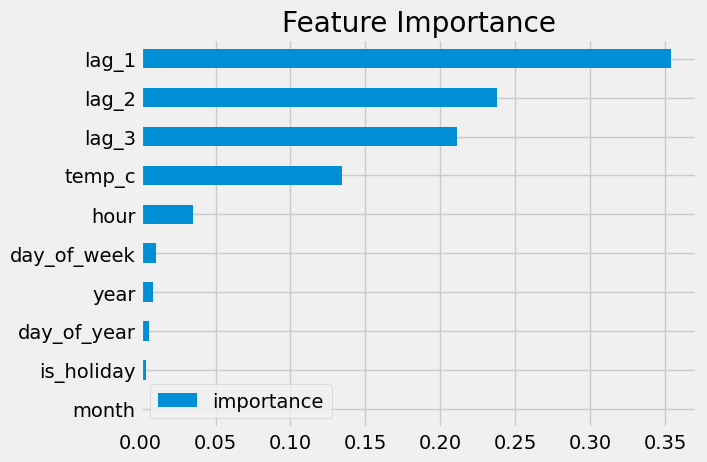

In [57]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

/var/folders/vs/7xtngmk97_368ytqy3yj8f6m0000gn/T/ipykernel_6087/4023921009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


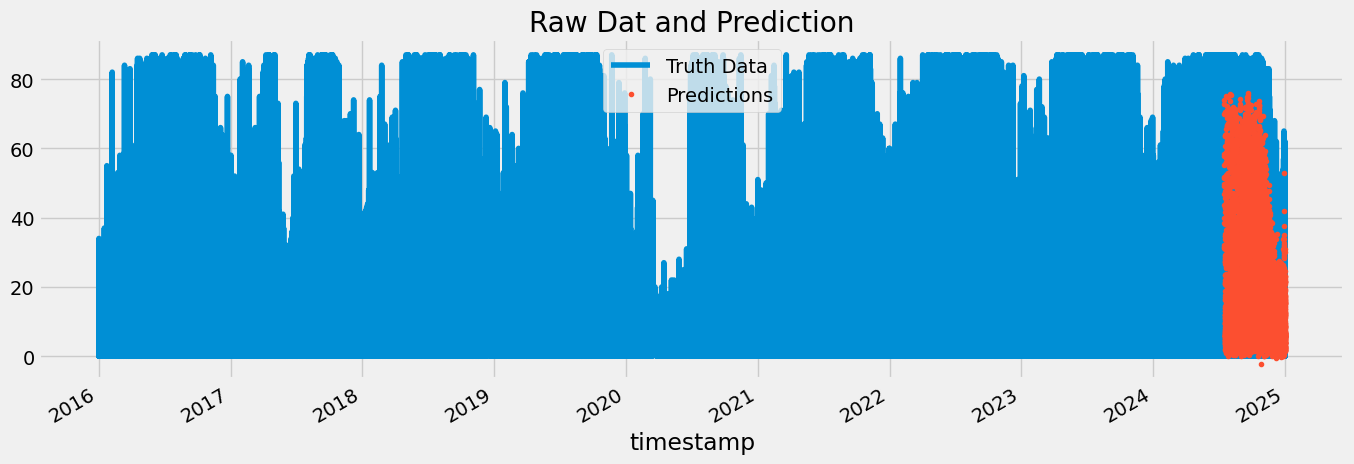

In [58]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['redemption_count']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

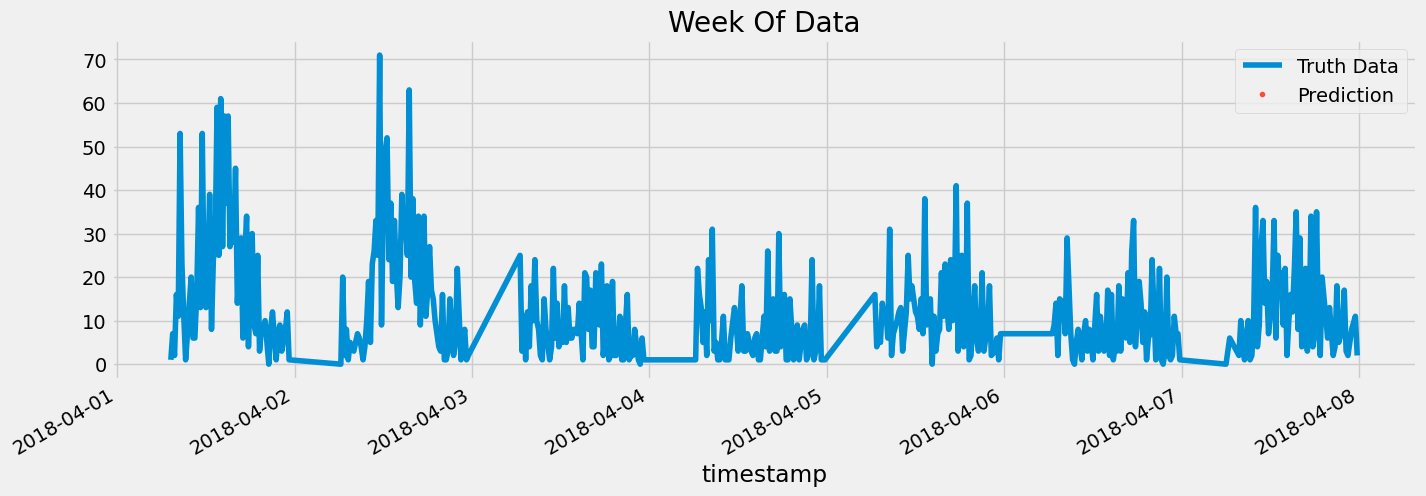

In [59]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['redemption_count'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

#### RMSE

In [60]:
score = np.sqrt(mean_squared_error(test['redemption_count'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 11.76


In [61]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2024-08-17    13.979352
2024-08-18    13.669650
2024-08-09    13.625375
2024-08-05    12.692255
2024-08-06    12.689731
2024-11-06    12.350376
2024-10-31    12.295278
2024-08-25    12.280258
2024-08-28    12.080046
2024-08-08    11.911960
Name: error, dtype: float64

#### MAPE

In [62]:
mean_absolute_percentage_error(test['redemption_count'], test['prediction'])

1100738512027648.0